# Training a VAEP model
_@Lutecity April 2023_

**Description**

VAEP is a football frameworkd whose purpose is to value an action regarding the impact on the game and the context of the situation. The values reflects the probability for the team to score or to concede a goal in the next actions.

This notebook contains codes and explanations about the training of a VAEP model that will be used in the application in order to provide insights on the technical performances of the players for the staff during the game.

In addition to the framework, we used the trained Model on a dataset of 326 FASWL games in order to provide information about the distribution of VAEP values for each action type for each type of player (simplify into Defender, Midfielder and Forward). 

We also decided to give more weight on offensive and defensive VAEP values regarding the positions of each players : we value their actions regarding the impact of them on the games but also regarding the role they are asked to play within this game.

The inspiration and large pieces of code come from [SoccerActions public notebooks](https://socceraction.readthedocs.io/en/latest/)

**Remaining work**

There is still remaning work to do regarding :
- choising a more suitable model (Catboost was the best option in the research article but was quite long to train)
- adding and testing some new relevant features

**References**

- _Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. “Actions speak louder than goals: Valuing player actions in soccer.” In Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, pp. 1851-1861. 2019._

- _Maaike Van Roy, Pieter Robberechts, Tom Decroos, and Jesse Davis. “Valuing on-the-ball actions in soccer: a critical comparison of xT and VAEP.” In Proceedings of the AAAI-20 Workshop on Artifical Intelligence in Team Sports. AI in Team Sports Organising Committee, 2020._


**Summary**

1. [Import the data](#data)
2. [Preprocessing into SPADL language](#preprocessing)
3. [Training](#training)
4. [Evaluating the model](#eval)
5. [VAEP values distibution by action and positions](#distribution)



In [115]:
# Import general libraries
import os
import warnings
import pandas as pd
import numpy as np
import tqdm
import pickle

# Import Socceractions tools
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab
import socceraction.atomic.vaep.labels as lab
import socceraction.atomic.vaep.formula as vaepformula

# Machine Learning 
from xgboost import XGBClassifier
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_calibration_curve

# Visualisation
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Import the data <a id="data"></a>

The data used for training the model is the [open data from Statsbomb](https://github.com/statsbomb/open-data). We focused on training the model with FA Women's Super League data from 2018 to 2021

In [77]:
# Local data
SBL = StatsBombLoader(getter="local", root="Data/StatsBombOpenData")
df_competitions = SBL.competitions()
df_competitions[df_competitions["competition_gender"] == 'female']

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
15,90,37,FA Women's Super League,England,female,2020/2021
16,42,37,FA Women's Super League,England,female,2019/2020
17,4,37,FA Women's Super League,England,female,2018/2019
38,3,49,NWSL,United States of America,female,2018
41,106,53,UEFA Women's Euro,Europe,female,2022
42,30,72,Women's World Cup,International,female,2019


In [78]:
# Recover the ids of competitions and seasons that we want
df_competitions_faswl = df_competitions[df_competitions["competition_name"] == "FA Women's Super League"]
list_competitions_id = list(zip(df_competitions_faswl.competition_id, df_competitions_faswl.season_id))

In [79]:
# Save the games
list_games = []
for competition, season in list_competitions_id : 
    list_games.append(SBL.games(competition_id=competition, season_id=season))
df_games = pd.concat(list_games)
df_games.sample(3)

,game_id,season_id,competition_id,competition_stage,game_day,game_date,home_team_id,away_team_id,home_score,away_score,venue,referee
71,19737,4,37,Regular Season,5,2018-10-14 15:00:00,966,970,2,1,Prenton Park,Helen Conley
25,3775620,90,37,Regular Season,4,2020-10-11 14:00:00,967,972,3,1,Walton Hall Park,Edward Duckworth
64,19750,4,37,Regular Season,8,2018-11-04 16:00:00,970,967,1,0,Clayson Stadium,Phillip Staynings


In [80]:
print("There are {} women games in the training set".format(len(df_games)))

There are 326 women games in the training set


In [81]:
# Store converted SPADL Data in a h5-file
datafolder = "Data/opendata-spadl"

## Preprocessing the data into SPADL <a id="preprocessing"></a>

Transform the data into a common language Atomic SPADL, whatever the provider. We are going to store the results in order no to re-transform the data.


#### Games, Atomic Actions, Players, Teams

In [82]:
%%script false --no-raise-error # To comment when using the notebook the 1st time

# Load and convert match data (games, actions, teams, players) from the training set
games_verbose = tqdm.tqdm(list(df_games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
atomic_actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    
    # convert data
    actions = spadl.statsbomb.convert_to_actions(events, game.home_team_id)
    atomic_actions[game.game_id] = atomicspadl.convert_to_atomic(actions)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

In [83]:
%%script false --no-raise-error # To comment when using the notebook the 1st time

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)

spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["games"] = df_games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in atomic_actions.keys():
        spadlstore[f"atomic_actions/game_{game_id}"] = atomic_actions[game_id]

#### Features & labels

In [84]:
# Define the state of a game as a set of 3 actions
nb_previous_actions = 3 

In [85]:
%%script false --no-raise-error # To comment when using the notebook the 1st time

# List the features we want to create and transform into atomic SPADL
xfns = [
    fs.actiontype,
    fs.actiontype_onehot,
    fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.movement_polar, 
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta,
]

features_h5 = os.path.join(datafolder, "atomic-features.h5")

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(features_h5) as featurestore:

    for game in tqdm.tqdm(list(df_games.itertuples()),desc=f"Generating and storing features in '{features_h5}'"):
        actions = spadlstore[f"atomic_actions/game_{game.game_id}"]

        # Convert actions to gamestate
        gamestates = fs.gamestates(atomicspadl.add_names(actions), nb_previous_actions) 
        gamestates = fs.play_left_to_right(gamestates, game.home_team_id)

        X = pd.concat([fn(gamestates) for fn in xfns], axis=1)
        featurestore[f"game_{game.game_id}"] = X

In [86]:
%%script false --no-raise-error # To comment when using the notebook the 1st time

# Compute Labels : goals scored and conceded
yfns = [lab.scores, lab.concedes] 

labels_h5 = os.path.join(datafolder, "atomic-labels.h5")

with pd.HDFStore(spadl_h5) as spadlstore, pd.HDFStore(labels_h5) as labelstore:
    for game in tqdm.tqdm(list(df_games.itertuples()), desc=f"Computing and storing labels in {labels_h5}"):
        actions = spadlstore[f"atomic_actions/game_{game.game_id}"]
        Y = pd.concat([fn(atomicspadl.add_names(actions)) for fn in yfns], axis=1)
        labelstore[f"game_{game.game_id}"] = Y

In [87]:
%%script false --no-raise-error # To comment when using the notebook the 1st time

# Take a look at the training data and target data
display(X.head())
display(X.columns)
display(Y.head())

## Training the model <a id="training"></a>

In [88]:
# Reading the data already transformed so we do not have to do at every launch of the notebook
spadl_h5 = os.path.join(datafolder, "atomic-spadl-statsbomb.h5")

df_games = pd.read_hdf(spadl_h5, key='games')
df_players = pd.read_hdf(spadl_h5, key='players')
df_teams = pd.read_hdf(spadl_h5, key='teams')

features_h5 = os.path.join(datafolder, "atomic-features.h5")
labels_h5 = os.path.join(datafolder, "atomic-labels.h5")

predictions_h5 = os.path.join(datafolder, "atomic-predictions.h5")

### Features & labels

In [89]:
# Features we take to train the model
list_features = [
    #fs.actiontype,
    fs.actiontype_onehot,
    #fs.bodypart,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.polar,
    fs.movement_polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta,
]

Xcols = fs.feature_column_names(list_features, nb_prev_actions=nb_previous_actions)
Ycols = ["scores", "concedes"]


In [90]:
# Training Data X
X = []
for game_id in tqdm.tqdm(df_games.game_id, desc="Selecting features"):
    Xi = pd.read_hdf(features_h5, f"game_{game_id}")
    X.append(Xi[Xcols])
X = pd.concat(X).reset_index(drop=True)

Selecting features: 100%|██████████| 326/326 [00:06<00:00, 47.32it/s]


In [91]:
# Target data Y
Y = []
for game_id in tqdm.tqdm(df_games.game_id, desc="Selecting label"):
    Yi = pd.read_hdf(labels_h5, f"game_{game_id}")
    Y.append(Yi[Ycols])
Y = pd.concat(Y).reset_index(drop=True)

Selecting label: 100%|██████████| 326/326 [00:03<00:00, 102.68it/s]


### Training

In [103]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.10,
    random_state=42,
    stratify=Y['scores'].astype(str) + '_' + Y['concedes'].astype(str)
)

In [162]:
from sklearn.calibration import CalibratedClassifierCV

In [191]:
# Training the XGBoost model
models = {}
for label in Ycols:
    print(label)
    model = XGBClassifier(
        eval_metric='auc', n_estimators=50, max_depth=3, n_jobs=-3, verbosity=1, use_label_encoder=False)
    model.fit(X_train, Y_train[label])
    models[label] = model


scores
concedes


In [93]:
# Save the model so it can be used later on the Manchester City 's game dataset
pkl_filename =  os.path.join("modeles/", "simple_VAEP_model.pkl")
with open(pkl_filename, 'wb') as file:
    pickle.dump(models, file)

## Evaluating the model <a id="eval"></a>

In [156]:
Y_pred = pd.DataFrame()

def evaluate(y, Y_hat):
    p = sum(y) / len(y)
    base = [p] * len(y)
    brier = brier_score_loss(y, Y_hat)
    print(f"  Brier score: %.5f (%.5f)" % (brier, brier / brier_score_loss(y, base)))
    ll = log_loss(y, Y_hat)
    print(f"  log loss score: %.5f (%.5f)" % (ll, ll / log_loss(y, base)))
    print(f"  ROC AUC: %.5f" % roc_auc_score(y, Y_hat))

for col in Y_test.columns:
    Y_pred[col] = [p[1] for p in models[col].predict_proba(X_test)]
    print(f"### Y: {col} ###")
    evaluate(Y_test[col], Y_pred[col])

### Y: scores ###
  Brier score: 0.00732 (0.81880)
  log loss score: 0.03540 (0.68816)
  ROC AUC: 0.90034
### Y: concedes ###
  Brier score: 0.00145 (0.93033)
  log loss score: 0.00922 (0.79360)
  ROC AUC: 0.86916


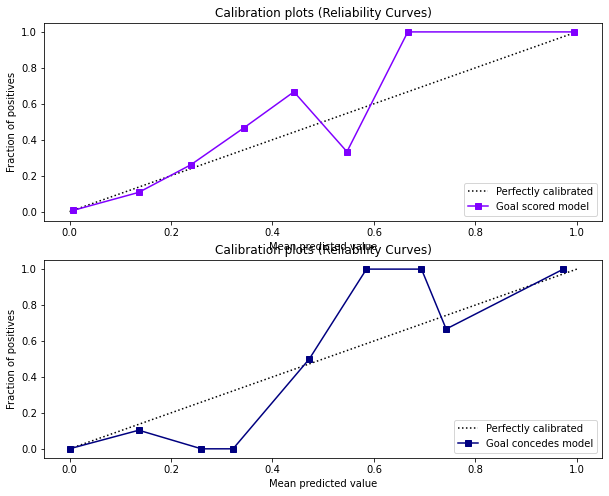

In [143]:
# Plot calibration curve and probability histogram
fig, (ax1, ax2) = plt.subplots( nrows=2, ncols=1, figsize=(10, 8))

plot_calibration_curve(
    y_true= Y_test['scores'],
    probas_list=[Y_hat['scores'].tolist()],
    clf_names=['Goal scored model'], n_bins=10, ax=ax1, cmap="rainbow")

plot_calibration_curve(
    y_true= Y_test['concedes'],
    probas_list=[Y_hat['concedes'].tolist()],
    clf_names=['Goal concedes model'], n_bins=10, ax=ax2, cmap="jet")

plt.show()

Calibrating the model

In [187]:
# Training the XGBoost model
calibrated_models = {}
for label in Ycols:
    print(label)
    model = XGBClassifier(
        eval_metric='auc', n_estimators=50, max_depth=3, n_jobs=-3, verbosity=1, use_label_encoder=False)
    calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
    calibrated.fit(X_train, Y_train[label])
    calibrated_models[label] = calibrated


scores
concedes


In [189]:
Y_pred_calib= pd.DataFrame()
for col in Y_test.columns:
    Y_pred_calib[col] = [p[1] for p in calibrated_models[col].predict_proba(X_test)]
    print(f"### Y: {col} ###")
    evaluate(Y_test[col], Y_pred_calib[col])

### Y: scores ###
  Brier score: 0.00727 (0.81375)
  log loss score: 0.03519 (0.68424)
  ROC AUC: 0.90055
### Y: concedes ###
  Brier score: 0.00144 (0.93016)
  log loss score: 0.00926 (0.79764)
  ROC AUC: 0.86108


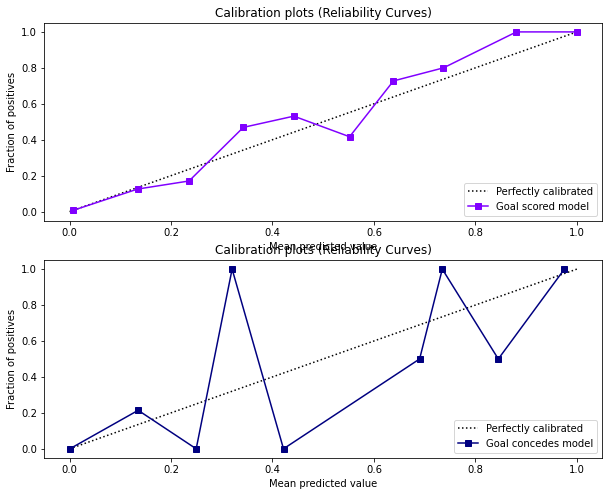

In [190]:
# Plot calibration curve and probability histogram
fig, (ax1, ax2) = plt.subplots( nrows=2, ncols=1, figsize=(10, 8))

plot_calibration_curve(
    y_true= Y_test['scores'],
    probas_list=[Y_pred_calib['scores'].tolist()],
    clf_names=['Goal scored model'], n_bins=10, ax=ax1, cmap="rainbow")

plot_calibration_curve(
    y_true= Y_test['concedes'],
    probas_list=[Y_pred_calib['concedes'].tolist()],
    clf_names=['Goal concedes model'], n_bins=10, ax=ax2, cmap="jet")

plt.show()

The calibrated model is better for the "score" predictions but worst for the "concede" prediction. We are going to choose the best for each one

In [193]:
mixed_models = {}
mixed_models["scores"] = calibrated_models["scores"]
mixed_models["concedes"] = models["concedes"]

In [194]:
# Save the model so it can be used later on the Manchester City 's game dataset
pkl_filename =  os.path.join("modeles/", "mixed_VAEP_model.pkl")
with open(pkl_filename, 'wb') as file:
    pickle.dump(mixed_models, file)

## VAEP values distibution by action and positions <a id="distribution"></a>

#### Compute VAEP values on the dataset

In [94]:
# Take the features of all the dataset and apply the model
A = []
for game_id in tqdm.tqdm(df_games.game_id, desc="Selecting features"):
    Ai = pd.read_hdf(features_h5, f"game_{game_id}")
    A.append(Ai[Xcols])
A = pd.concat(A).reset_index(drop=True)

Y_pred = pd.DataFrame()
for col in ["scores", "concedes"]:
    Y_pred[col] = [p[1] for p in models[col].predict_proba(A)]

Selecting features: 100%|██████████| 326/326 [00:06<00:00, 47.60it/s]


In [ ]:
# Take the whole dataset
B = []
for game_id in df_games.game_id:
    actions = pd.read_hdf(spadl_h5, f"atomic_actions/game_{game_id}")
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left")
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
        )
    B.append(actions)
B = pd.concat(B)
B = B.reset_index(drop=True)


# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([B, Y_pred], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_pred.columns].to_hdf(predictions_h5, f"game_{int(k)}")

In [ ]:
# In case we direcly want to load the predictions
A = []
for game in list(df_games.itertuples()):
    actions = pd.read_hdf(spadl_h5, f"atomic_actions/game_{game.game_id}")
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictions_h5, f"game_{game.game_id}")
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.head()


,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played,team_name,scores,concedes,offensive_value,defensive_value,vaep_value
0,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,0,1,0.0,971,4647.0,52.058824,33.569620,-1.764706,-2.582278,0,5,pass,foot_right,So-Yun Ji,Ji So-yun,10,True,14,Center Midfield,97,Chelsea FCW,0.003390,0.000465,0.000000,-0.000000,0.000000
1,7298,2a456ec2-352c-499b-b5cc-e68bf84c7e9a,1,1,0.0,971,4659.0,50.294118,30.987342,0.000000,0.000000,23,0,receival,foot,Ramona Bachmann,None,23,True,24,Left Center Forward,94,Chelsea FCW,0.003700,0.000479,0.000309,-0.000014,0.000296
2,7298,7e908bd8-8e2f-44f8-9cc6-0435cd9ed3ed,2,1,0.0,971,4659.0,50.294118,30.987342,-5.294118,-3.443038,21,0,dribble,foot,Ramona Bachmann,None,23,True,24,Left Center Forward,94,Chelsea FCW,0.005626,0.000314,0.001927,0.000165,0.002092
3,7298,38023613-6b26-44e2-a0f8-9aab9960d2ff,3,1,0.0,971,4659.0,45.000000,27.544304,-13.235294,-24.101266,0,5,pass,foot_right,Ramona Bachmann,None,23,True,24,Left Center Forward,94,Chelsea FCW,0.012132,0.000280,0.006506,0.000034,0.006540
4,7298,38023613-6b26-44e2-a0f8-9aab9960d2ff,4,1,1.0,971,5088.0,31.764706,3.443038,0.000000,0.000000,23,0,receival,foot,Crystal Alyssia Dunn Soubrier,Crystal Dunn,19,True,16,Left Midfield,97,Chelsea FCW,0.006442,0.000096,-0.005690,0.000183,-0.005506


#### Use Positions 

In [ ]:
# Adding the position name of the player at each action

# Getting the events so we can add the information
list_events = []
games_verbose = tqdm.tqdm(list(df_games.itertuples()), desc="Loading game data")
for game in games_verbose:
    list_events.append(SBL.events(game.game_id))

events = pd.concat(list_events)

df_vaep_position = A.merge(events[["event_id", "player_id", "position_name"]], 
                                                     how='left', 
                                                    left_on=["original_event_id", "player_id"],
                                                    right_on = ["event_id", "player_id"])

Loading game data: 100%|██████████| 326/326 [00:48<00:00,  6.69it/s]


In [ ]:
# If we don't have the position of the player at a certain event, we take her starting position name
df_vaep_position.loc[
    df_vaep_position["position_name"].isna(), "position_name"] = df_vaep_position.loc[
    df_vaep_position["position_name"].isna(), "starting_position_name"]

# If we don't have the position name nor the starting position name as the player is a substitue, we remplace by NaN
df_vaep_position.loc[ df_vaep_position["position_name"] == "Substitute", "position_name"] = np.NaN

In [ ]:
# Weight the offensive and defensive values regarding the position of the name
value_poste = pd.read_csv("poste.csv", sep=";").set_index("position_name").to_dict("index")
value_poste["Left Defensive Midfield"]

{'type': 'Midfield', 'offensive': 0.34, 'defensive': 0.66}

In [ ]:
# Drop the rows where is no information about the position
df_vaep_position = df_vaep_position[~df_vaep_position["position_name"].isna()]

In [ ]:
#Group by general type of position : Forward, Midfielder, Defender
df_vaep_position["poste_type"] = df_vaep_position["position_name"].apply(lambda x : value_poste[x]["type"])

In [ ]:
distribution_position_actions = df_vaep_position[
    ["type_name", "poste_type", "offensive_value", "defensive_value"]].groupby(["type_name", "poste_type"]).describe()

In [ ]:
distribution_position_actions.sample(4)

offensive_value                                          \
                               count      mean       std       min       25%   
type_name poste_type                                                           
freekick  Forward              403.0 -0.011010  0.033642 -0.239238 -0.021512   
corner    Forward              837.0  0.008028  0.031887 -0.284337 -0.002550   
receival  Defender           91301.0  0.000680  0.009703 -0.137658 -0.000132   
cross     Midfield            1801.0  0.014579  0.019101 -0.155485  0.009607   

                                                   defensive_value            \
                           50%       75%       max           count      mean   
type_name poste_type                                                           
freekick  Forward    -0.003520  0.004763  0.192634           403.0  0.000312   
corner    Forward     0.012018  0.025326  0.099301           837.0  0.000167   
receival  Defender    0.000081  0.000423  0.372446         91301.0  0.000419   
cross     Midfield    0.016107  0.023494  0.114195          1801.0 -0.000008   

                                                                            \
                           std       min       25%       50%           75%   
type_name poste_type                                                         
freekick  Forward     0.001854 -0.000775  0.000019  0.000072  1.532379e-04   
corner    Forward     0.000214 -0.000220  0.000017  0.000062  3.148151e-04   
receival  Defender    0.003130 -0.158414  0.000008  0.000163  4.803803e-04   
cross     Midfield    0.000086 -0.001201 -0.000034 -0.000016 -2.983215e-07   

                                
                           max  
type_name poste_type            
freekick  Forward     0.028636  
corner    Forward     0.001157  
receival  Defender    0.236192  
cross     Midfield    0.001524

In [171]:
# Save the value of mean and std
df_to_save = distribution_position_actions[
    [('offensive_value',  'mean'),
    ('offensive_value',   'std'),
    ('defensive_value',  'mean'),
    ('defensive_value',   'std')
    ]]

df_to_save.sample(10)

offensive_value           defensive_value          
                                  mean       std            mean       std
type_name   poste_type                                                    
foul        Midfield         -0.003350  0.017192       -0.012234  0.044630
out         Goalkeeper       -0.001308  0.002979        0.000225  0.000722
cross       Forward           0.013546  0.020033       -0.000011  0.000060
goalkick    Defender          0.000800  0.000955        0.016786  0.052530
throw_in    Forward          -0.000196  0.023430        0.000632  0.006116
red_card    Goalkeeper        0.000463  0.000068        0.081180  0.015279
tackle      Defender          0.001559  0.004345        0.014100  0.023668
throw_in    Defender          0.001148  0.005159        0.000762  0.003864
clearance   Forward           0.000355  0.001434        0.006228  0.038478
yellow_card Midfield          0.005685  0.017242        0.000548  0.019597

In [183]:
# Save the data 
df_to_save = df_to_save.reset_index()
df_to_save.to_csv("matrice_vaep.csv")

,Unnamed: 0,type_name,poste_type,offensive_value,offensive_value.1,defensive_value,defensive_value.1
0,NaN,NaN,NaN,mean,std,mean,std
1,0.0,bad_touch,Defender,-0.008132525719702244,0.02078249864280224,-0.013118524104356766,0.0840504914522171
2,1.0,bad_touch,Forward,-0.01237756572663784,0.023891212418675423,-0.001612897147424519,0.019894596189260483
3,2.0,bad_touch,Goalkeeper,-0.00023956700169946998,0.00017580781423021108,-0.46958503127098083,0.34663695096969604
4,3.0,bad_touch,Midfield,-0.008805385790765285,0.018521007150411606,-0.00224114372394979,0.016161169856786728
